In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from celeb import CelebDatasetFast
from torchsummary import summary

In [4]:
batch_size = 5 
dataset_size = 1000

In [5]:
transform = transforms.Compose([transforms.PILToTensor(), transforms.Lambda(lambda x: x/255), transforms.Resize([256,256], antialias=True)])


train_dataset = CelebDatasetFast(
    split='train', transform=transform,total=dataset_size, mask_size=(256, 256, 3))

test_dataset = CelebDatasetFast(
    split='test', transform=transform,total=dataset_size, mask_size=(256, 256, 3))

val_dataset = CelebDatasetFast(
    split='val', transform=transform,total=dataset_size, mask_size=(256, 256, 3))

train_loader = DataLoader(train_dataset, batch_size, True)
test_loader = DataLoader(test_dataset, batch_size, False)
val_loader = DataLoader(val_dataset, batch_size, False)

200


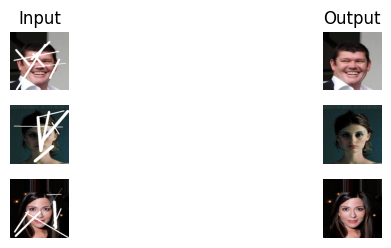

In [6]:

print(len(train_loader))
examples = iter(train_loader)
samples = next(examples)
inp, mask= samples[0], samples[1]
target = samples[2]
# print(inp.shape)
# print(inp[0])
# print(target.shape)

for k in range(0, 6, 2):
    i = inp[k].permute((1, 2, 0))
    plt.subplot(6, 2, k+1)
    if k == 0:
        plt.title("Input")
    plt.axis("off")
    plt.imshow(i)
    o = target[k].permute((1, 2, 0))
    plt.subplot(6, 2, k+2)
    if k == 0:
        plt.title("Output")
    plt.axis("off")
    plt.imshow(o)

plt.subplots_adjust(left=0.05,
                    bottom=0.05,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)
plt.tight_layout()
plt.savefig("train.png")
plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_epochs = 50 
learning_rate = 1e-4 #better is 3e-4
LAMBDA_DICT = {
    'valid': 1.0, 'hole': 6.0, 'tv': 0.1, 'prc': 0.05, 'style': 120.0}

cuda


In [8]:
from net import PConvUNet
from loss import CalculateLoss

cuda


In [9]:
iterator_train = iter(train_loader)
image, mask, gt = [x.to(device) for x in next(iterator_train)]
print(image.shape)
print(mask.shape)
print(gt.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


In [10]:
model = PConvUNet().to(device)
criterion = CalculateLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameters in the model:", total_params)

Total parameters in the model: 25779796


In [ ]:
model.train();

In [ ]:
#model.load_state_dict(torch.load("./09-04-2024(15-20).pth"))
import torch
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

def evaluate_model(image1_tensor, image2_tensor):
    # Convert tensors to numpy arrays
    img1 = image1_tensor.cpu().detach().numpy()
    img2 = image2_tensor.cpu().detach().numpy()

    # Normalize image values to [0, 1]
    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0

    # Calculate SSIM
    ssim_value, _ = ssim(img1, img2, full=True)

    # Calculate PSNR
    psnr_value = psnr(img1, img2)

    return ssim_value, psnr_value

In [ ]:
from tqdm.notebook import trange, tqdm
train_losses= {}
val_losses = {}
min_loss = float("inf")
for epoch in tqdm(range(num_epochs), desc="Epoch", unit="epoch"):
    model.train()
    training_loss = 0
    for input_images,masks,target_images in tqdm(train_loader,desc=f"Training batches", unit="batch", leave=False):
        input_images = input_images.to(device)
        masks = masks.to(device)
        target_images = target_images.to(device)
        # print(input_images.shape)
        # print(masks.shape)
        # print(target_images.shape)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, _ = model(input_images, masks)
        train_loss = criterion(input_images, masks, outputs, target_images)
        # train_loss = 0.0
        # for key, coef in LAMBDA_DICT.items():
        #     value = coef * loss_dict[key]
        #     train_loss += value

        # compute training reconstruction loss
        # train_loss = criterion(input_images, masks, outputs, target_images)
        # train_loss = criterion(outputs, target_images) 
        # print(train_loss)
        
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        training_loss += train_loss.item()
    
    # compute the epoch training loss
    training_loss = training_loss / len(train_loader)
    train_losses[epoch] = training_loss

    model.eval()

    with torch.no_grad():
        validation_loss = 0
        for input_images,masks, target_images in tqdm(val_loader,desc=f"Validation batches", unit="batch", leave=False):
            input_images = input_images.to(device)
            masks = masks.to(device)
            target_images = target_images.to(device)
            
            
            outputs,_ = model(input_images, masks)
            
            # compute training reconstruction loss
            # val_loss = criterion(input_images, masks, outputs, target_images)
            #val_loss = criterion(outputs, target_images)

            val_loss = criterion(input_images, masks, outputs, target_images)
            # val_loss = 0.0
            # for key, coef in LAMBDA_DICT.items():
            #     value = coef * loss_dict[key]
            #     val_loss += value
            
            
            
            # add the mini-batch training loss to epoch loss
            validation_loss += val_loss.item()
        validation_loss = validation_loss / len(val_loader)
        val_losses[epoch] = validation_loss

    
    # display the epoch training loss
    if validation_loss < min_loss:
        min_loss = validation_loss
        torch.save(model.state_dict(), f'{epoch}_epoch.pth')

    print("Epoch : {}/{}, Training Loss = {:.6f}, Validation Loss = {:.6f}".format(epoch, num_epochs, training_loss, validation_loss))

In [ ]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the current date as a string in the "YYYY-MM-DD" format
formatted_date = current_datetime.strftime("%d-%m-%Y(%H-%M)")

import json
with open(f'trainlosses_{formatted_date}.json', 'w') as fp:
    json.dump(train_losses, fp)

with open(f'vallosses_{formatted_date}.json', 'w') as fp:
    json.dump(val_losses, fp)

torch.save(model.state_dict(), f'{formatted_date}.pth')
print("Model Saved.")

In [ ]:
model.eval();

In [ ]:
import torchvision
def tensorToPIL(t):
    return torchvision.transforms.functional.to_pil_image(t, "RGB")


def save_tensor_as_image(t,name):
    img = tensorToPIL(t) 
    img.show()
    img.save(name)

In [ ]:
with torch.no_grad():
    h,w = 256,256
    model = model.to('cpu')

    test_loader = DataLoader(test_dataset, batch_size, True)
    examples = iter(test_loader)

    inputs, masks, targets = next(examples)


    outputs, _ = model(inputs, masks)


    # print(outputs.shape)
    # save_tensor_as_image(outputs[1], "ouput.png")
    rows = 3
    cols = 3
    for i in range(1,rows*cols,cols):
        input = inputs[i%batch_size].reshape(3, h, h).permute(1,2,0)
        # input = input.cpu().numpy()

        output = outputs[i%batch_size].reshape(3, h, h).permute(1,2,0)
        # output = output.cpu().numpy()

        target = targets[i%batch_size].reshape(3, h, h).permute(1,2,0)
        # target = target.cpu().numpy()

        # print(output.shape)
        # input
        plt.subplot(rows,cols,i)
        if i == 1:
            plt.title("Input")
        plt.imshow(input)
        #output
        plt.subplot(rows,cols,i+1)
        if i == 1:
            plt.title("Output")
        plt.imshow(output)
        # ground truth
        plt.subplot(rows,cols,i+2)

        if i == 1:
            plt.title("Ground Truth")
        plt.imshow(target)
    plt.subplots_adjust(left=0.1,
                        bottom=0.05,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)
    plt.show()